# Introduction
In this homework we will train a neural machine translation system to translate sentences from English to French.
To achieve this, we will use a sequence-to-sequence model proposed by Sutskever et al, "Sequence to sequence learning with neural networks". Sequence-to-sequence (seq2seq) models have become almost standard in NLP, and you will find a brief description of the original model architecture below.

__You will need__ to have the following libraries installed (please make sure you followed the installation instructions in the class repository to install them):
- [NLTK](http://www.nltk.org/)
- [NumPy](http://www.numpy.org/)
- [PyTorch](https://pytorch.org/)
- [scikit-learn](https://scikit-learn.org/stable/)


__You will learn:__
- How to create a sequence-to-sequence machine translation model
- How to implement this model with recurrent neural networks using GRU cells

Once you complete this assignment, submit it as:

`submit arum hw5 <name_of_your_notebook> <additional_files>`


In [0]:
# Make sure that execution of this cell doesn't return any errors. If it does, go the class repository and follow the environment setup instructions
import itertools
from collections import Counter, defaultdict

import torch
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn')
%matplotlib inline

# Sequence-to-Sequence model

A sequence-tosequence (seq2seq) model consists of an encoder, which encodes an input sentence (an english sentence) into a fixed-length vector $z$, and a decoder, which then decodes this hidden vector into an output sentence (a corresponding translation to French). The figure below illustrates the diagram of the model (taken from [Tesnorflow Neural Machine Translation Tutorial](https://github.com/tensorflow/nmt), for details).

<center>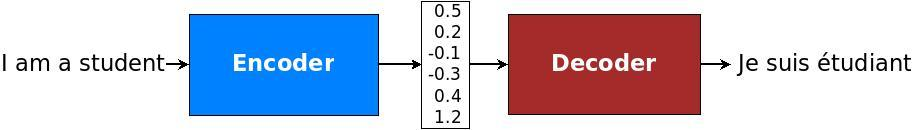
    </center>

Note that the encoder here is very similar (in fact, almost the same) to the encoder you had used in the previous homework. The only difference is that here you need to use __only the last__ hidden state for every sentence in a batch to obtain the vector $z$. The decoder is conceptually similar and it just decodes the output sequence one token at a time. See the figure below, taken from the same tutorial, for details.

<center>
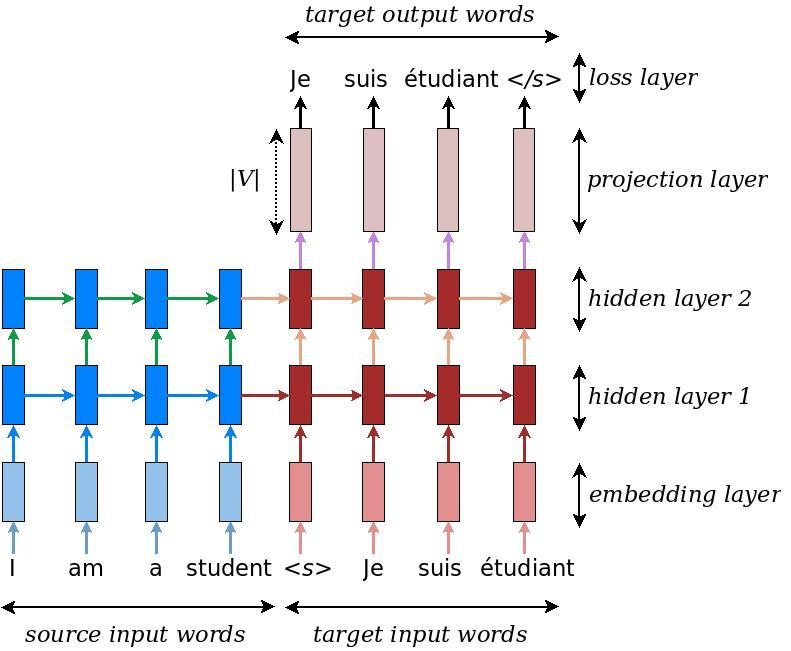
</center>


Note that at the first timestep of the decoder its hidden state is initialized with the vector $z$ and it accepts a special "start" token as the input (`<s>` on the figure above). After that, it receives its own output produced at the previous timestep as an input for the current timestep. This process continues either until the decoder produces a special "end" token (`</s>` on the figure above) or until a predifined maxmimum length of a sequence is reached.

## 1. French-English translation data

As the training data we will use the data from http://www.manythings.org/anki/. It contains 135842 English sentences with the corresponding French translation. For simplicity, we filter out long sentences so the resulting training set contains 119854 pairs and the validation set contains 5000 pairs.

__Instructions__:
- Complete the code below for loading the data from the file.

__Notes__:
- Make sure you have the file `eng-fra.txt` in the same directory as this notebook.



### 1.1 Loading the data
Note that the input (english) and the target (french) sentences in the file `eng-fra.txt` are separated by `\t` and each training example is on a separate line. The `data` list should contain tuples of `<input, target>` pairs:
```
data = [
    ['Tom had blood on his shoes.', 'Tom avait du sang sur ses chaussures.'],
    ['She was appointed chairperson.', 'Elle fut nommée présidente.'],
    ['That is simply not true.', "Ce n'est simplement pas vrai."],
    ...
]
```

In [0]:
data = []

### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

#### 1.1.1 How many examples are there? Print out the 90001th example

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 1.2 Filtering the data
For simplicity, filter out the samples that have more than 7 spaces (`' '`) in either input or target sentence. Roughly, this corresponds to filtering out samples with more than 10 tokens.

In [0]:
nb_max_spaces = 7

### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

#### 1.2.1 How many examples are there now? Print out the 90001th example.

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 1.4 Tokenization

__Instructions__:
- Complete the code in the cell below that, given a list of tuples of sentences, outputs a list of tuple of tokens contained in a given sentence.

__Notes__: 
- You should use nltk's `word_tokenize` function
- Lowercase tokens after the tokenizaton

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

#### 1.4.1 Print out the tokenized 90001-th sample.

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 1.5 Splitting the data

As usual, you should create a train and a test split. Split the data in the 70%/30% proportion.

__Notes__: 
- You should use the `train_test_split` function.
- __Make sure to set `random_state` to `42`__ for the consistency of the results.

In [0]:
### YOUR CODE BELOW ###
data_train, data_test = None, None
### YOUR CODE ABOVE ###

#### 1.5.1 How many examples are there in the train and the test splits? Print out the 50001th training sample.

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

## 2. Seq2seq neural translation model

To train a seq2seq model, you would need the following classes:

 - A vocabulary class (you can re-use it from the previous homeworks)
 - A dataset class that provides the input and the target sequences
   - Note that this class would need to use **two** separate vocabularies: one for English and one for French
 - A model class that implements the seq2seq model itself

### 2.1. Building the vocabulary
You are going to re-use the vocabulary class from your previous homeworks. Simply run the cell below.

In [0]:
class Vocabulary:
    def __init__(self, special_tokens=None):
        self.w2idx = {}
        self.idx2w = {}
        self.w2cnt = defaultdict(int)
        self.special_tokens = special_tokens
        if self.special_tokens is not None:
            self.add_tokens(special_tokens)

    def add_tokens(self, tokens):
        for token in tokens:
            self.add_token(token)
            self.w2cnt[token] += 1

    def add_token(self, token):
        if token not in self.w2idx:
            cur_len = len(self)
            self.w2idx[token] = cur_len
            self.idx2w[cur_len] = token

    def prune(self, min_cnt=2):
        to_remove = set([token for token in self.w2idx if self.w2cnt[token] < min_cnt])
        to_remove ^= set(self.special_tokens)

        for token in to_remove:
            self.w2cnt.pop(token)

        self.w2idx = {token: idx for idx, token in enumerate(self.w2cnt.keys())}
        self.idx2w = {idx: token for token, idx in self.w2idx.items()}

    def __contains__(self, item):
        return item in self.w2idx

    def __getitem__(self, item):
        if isinstance(item, str):
            return self.w2idx[item]
        elif isinstance(item , int):
            return self.idx2w[item]
        else:
            raise TypeError("Supported indices are int and str")

    def __len__(self):
        return(len(self.w2idx))

__Instructions__:
- Initialize 2 `Vocabulary` classes (one for English and one for French) and populate both of them with corresponding tokens
- Use the following special tokens for the both objects: `'<PAD>'`, `'<S>'` (sentence start), `'</S>'` (sentence end), `'<UNK>'`
   - **Important**: conventionally, the pad token has the index `0` (and it is also more convenient for debugging). To achieve this, make it the first element of the `special_tokens` list.

__Notes__:
- Remember to use only the train subset of the data for populating your vocabularies with tokens. 
- Recall that your `train_data` is a list of tuple of lists (yep, sounds complicated). Make sure you are passing the correct input to the `add_tokens` method of every vocabulary. You might find `itertools` useful here.

In [0]:
### YOUR CODE BELOW ###
voc_eng = None

voc_fr = None
### YOUR CODE ABOVE ###

#### 2.1.1. What is the size of the english vocabulary and what is the size of the french vocabulary? Print out the token with the `id=42` in the french vocabulary.

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 2.2. Building the dataset

Recall that the goal of your model is to return a sentence in French given a sentence in English. Therefore, a single training example is a given sentence in English (a sequence of words converted to their word ids), and the corresponding given French sentence is a sequence of target labels. Having this logic in mind, complete the missing code in the `TranslationDataset` class. 

__Instructions__:
- Complete the `_preprocess()` method that crops the sentence if it exceeds the maximum length, pads them to the maximum length, and converts the tokens to their vocabulary ids
- Complete the `__getitem__()` method that returns input and target tensors containing token ids
- Complete the code in the cells below to answer the questions

__Notes__:
- Make sure to use the correct vocabulary when you convert a sentence to a sequence of ids.
- Make sure to append the end-of-sentence token `</S>` to each input sentence.
- Make sure to replace tokens that are missing in your vocabulary with the `<UNK>` token.

In [0]:
class TranslationDataset(Dataset):
    def __init__(self, data, voc_eng, voc_fr, max_len=15):
        super().__init__()
        
        self.voc_eng = voc_eng
        self.voc_fr = voc_fr
        self.max_len = max_len
        
        self.data = [self._preprocess(example) for example in data]
        
    def _preprocess(self, sentence_pair):
        """
        Preprocess a single pair of sentences
        Args:
            sentence_pair (list, list): input pair of sentences represented as lists of tokens
            max_len (int, optional): maximum sequence length to pad to 
        
        Returns:
            (list, list): a tuple of lists of max_len with token ids 
        
        """
        sentence_eng, sentence_fr = sentence_pair
        
        ### YOUR CODE BELOW ###
        
        # Process English sentence
        
        # Process French sentence

        ### YOUR CODE ABOVE ###
        return sentence_eng, sentence_fr
            
    def __getitem__(self, idx):
        """
        Get a single training example
        
        Args:
            idx (int): input index
        
        Returns:
            (inputs, targets): a tuple of torch.LongTensor
        """
        ### YOUR CODE BELOW ###
        
        inputs, targets = None, None

        ### YOUR CODE ABOVE ###
        return inputs, targets
    
    def __len__(self):
        return len(self.data)

In [0]:
### YOUR CODE IS BELOW ###
dataset_train = None
dataset_test = None
### YOUR CODE IS ABOVE ###

#### 2.2.1 Print out the training `TranslationDataset` example with the index 100

In [0]:
### YOUR CODE IS BELOW ###

### YOUR CODE IS ABOVE ###

#### 2.2.2 What are the corresponding English and French sentences?

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 2.3 Building the seq2seq model 

__Instructions__:
- Complete the code in `__init__()`, `encode()`, `decode()` and `forward()` relying on the diagram of the model architecture.

__Notes__:
- This model would have two embedding layers: one for the input English sentence and one for the output French sentence
- It is easier to use the `torch.nn.GRU` class for the encoder, as it automatically runs the GRU unit for all timesteps
- However, for the decoder it is better to the `torch.nn.GRUCell` class, since we __only know the input to the decoder at a current timestep after the output of the previous timestep was generated__.  This class implements a GRU cell and you would need to use it at every iteration of a decoding loop. Please refer to the documentation of both classes for details ([GRU](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU), [GRUCell](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRUCell)). 
- To speed up the convergence of the model you will use a technique called 'teacher forcing'. With teacher forcing, at train time with a probability $p$ at the timestep $t$ the decoder receives not the output of the previous timestep $t-1$ but the target token that should have been produced at the timestep $t-1$. This technique helps to stabilize the start of traning when the model is not sure what tokens it should produce. Obviously, this is not possible (and should not be done) at test time, as we do not know the true tokens.

In [0]:
class Seq2SeqModel(torch.nn.Module):
    def __init__(self, embedding_size, vocab_eng_size, vocab_fr_size, hidden_size, teacher_forcing, max_len, start_index, end_index, pad_index):
        """
        Initialize the seq2seq model

        Args:
           embedding_size (int): the size of the embedding layer (will be the same for both English and French)
           vocab_eng_size (int): the size of the English vocabulary
           vocab_fr_size (int): the size of the French vocabulary
           hidden_size (int): the size of GRU unit
           teacher_forcing (float): teacher forcing probability
           max_len (int): maximum length of the sentence
           start_index (int): index of the `<S>` token
           end_index (int): index of the `</S>` token
           pad_index (int): index of the `<PAD>` token
        """


        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.teacher_forcing = teacher_forcing
        self.vocab_eng_size = vocab_eng_size
        self.vocab_fr_size = vocab_fr_size

        self.max_len = max_len
        self.start_index = start_index
        self.end_index = end_index
        self.pad_index = pad_index

        ### YOUR CODE BELOW ###

        
        ### YOUR CODE ABOVE ###
        
            
    def encode(self, inputs):
        """
        Encode a batch of inputs and produce a batch of hidden states
        
        Args:
            inputs (torch.LongTensor): input token ids
        
        Returns:
            torch.FloatTensor: hidden layer at the last timestep
        """
        
        ### YOUR CODE BELOW ###

        h_last_hidden = None

        ### YOUR CODE ABOVE ###
        
        return h_last_hidden
    
    def decode(self, decoder_hidden, targets=None):
        """
        Encode a batch of inputs and produce a batch of hidden states
        
        Args:
            decoder_hidden (torch.FloatTensor): last time step of encoded sentence
            targets (torch.LongTensor, optional): target token ids (at train time)
        
        Returns:
            torch.FloatTensor: sequence of unnormalized predicted probability distributions over vocabulary
        """
        
        ### YOUR CODE BELOW ###

        outputs_logits = None
            
        ### YOUR CODE ABOVE ###
            
        return outputs_logits
        
    def forward(self, inputs, targets=None):
        """
        Perform a forward model pass
        
        Args:
            inputs (torch.LongTensor): input word ids
            targets (torch.LongTensor): target word ids (at train time)
            
        Returns:
            torch.FloatTensor: sequence of unnormalized predicted probability distributions over vocabulary
        """
        
        ### YOUR CODE BELOW ###

        outputs_logits = None

        ### YOUR CODE ABOVE ###

        return outputs_logits

## 3. Training

Carefully read through the cell below to understand the parameters passed to the network. 

In [0]:
# DATALOADER #
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=64)

# MODEL INITIALIZATION #
model = Seq2SeqModel(
    embedding_size=300, 
    vocab_eng_size=len(voc_eng), 
    vocab_fr_size=len(voc_fr), 
    hidden_size=256,
    teacher_forcing=0.7,
    max_len=dataset_train.max_len, 
    start_index=voc_fr['<S>'], 
    end_index=voc_fr['</S>'], 
    pad_index=voc_fr['<PAD>'],
)

if torch.cuda.is_available():
    model = model.to('cuda')

# OPTIMIZER #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LOSS-FUNCTION #
criterion = torch.nn.CrossEntropyLoss()

### 3.1 Training loop


__Instructions__:
- Complete the training loop cell below to train your model. You can rely (not just copy-paste, as there will be modifications) on the training loops from previous homeworks.

__Notes__:
- You have to reshape the output and the target tensors to compute the loss function (refer to the [documentation](https://pytorch.org/docs/stable/nn.html#crossentropyloss) of cross entropy). Use the `view()` method of `torch.Tensor` to reshape tensors.

__Warning__: 
- Training can take a while. __Make sure you use GPUs__ and have tested your implementation on a smaller subset of the train dataset.

In [0]:
# TRAINING #
losses = []
for epoch in range(15):
    epoch_losses = []
    for i, batch in enumerate(dataloader_train):
        ### YOUR CODE BELOW ###
        
        ### YOUR CODE ABOVE ###
        
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    print('Epoch {}, loss {}'.format(epoch, epoch_loss))

### 3.2. Plot the training losses
Plot the training losses against epochs to verify the convergence of the model.

__Instructions__:
- Complete the code in the cell below.

In [0]:
### YOUR CODE BELOW ###

### YOUR CODE ABOVE ###

### 3.3 Translation of arbitrary sentences
Now that the model is trained, you can use it to translate arbitrary sentences from English to French (yay!).

__Instructions__:
- Complete the function below to translate an arbitrary input sentence (one at a time) using your model

__Notes__:
- You can use the already implemented `_preprocess()` method of the `TranslationDataset` to convert an str sentence to a numeric representation.

In [0]:
def translate_sentence(sentence, model, dataset):
    """
    Translate a sentence from English to French using the trained model

    Args:
        sentence (str): input English sentence 
        model (Seq2SeqModel): a trained model
        dataset (TranslationDataset): dataset that will be used to preprocess the input sentence

    Returns:
        str: a French translation of the input English sentence
    """    
    
    ### YOUR CODE BELOW ###
    
    sentence_french = ''

    ### YOUR CODE ABOVE ###
    
    return sentence_french

Let's test the model on the arguably most famous French sentence _this is life_!

__Instructions__:
- Run the cells below to see what translation you get.

__Notes__:
- Feel free to translate arbitrary sentences of your choice upon completion of this homework.

In [0]:
test_sentence_eng = 'this is life!'
test_sentence_fr_true = "c'est la vie!"

In [0]:
test_sentence_fr_pred = translate_sentence(test_sentence_eng, model, dataset_train)

In [0]:
print('Input:\n', test_sentence_eng)
print('Translation:\n', test_sentence_fr_pred)
print('True translation:\n', test_sentence_fr_true)